In [246]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.providers.fake_provider import GenericBackendV2 as GenericBackend
from qiskit_ibm_runtime import SamplerV2 as Sampler 
from qiskit_aer import AerSimulator

import random

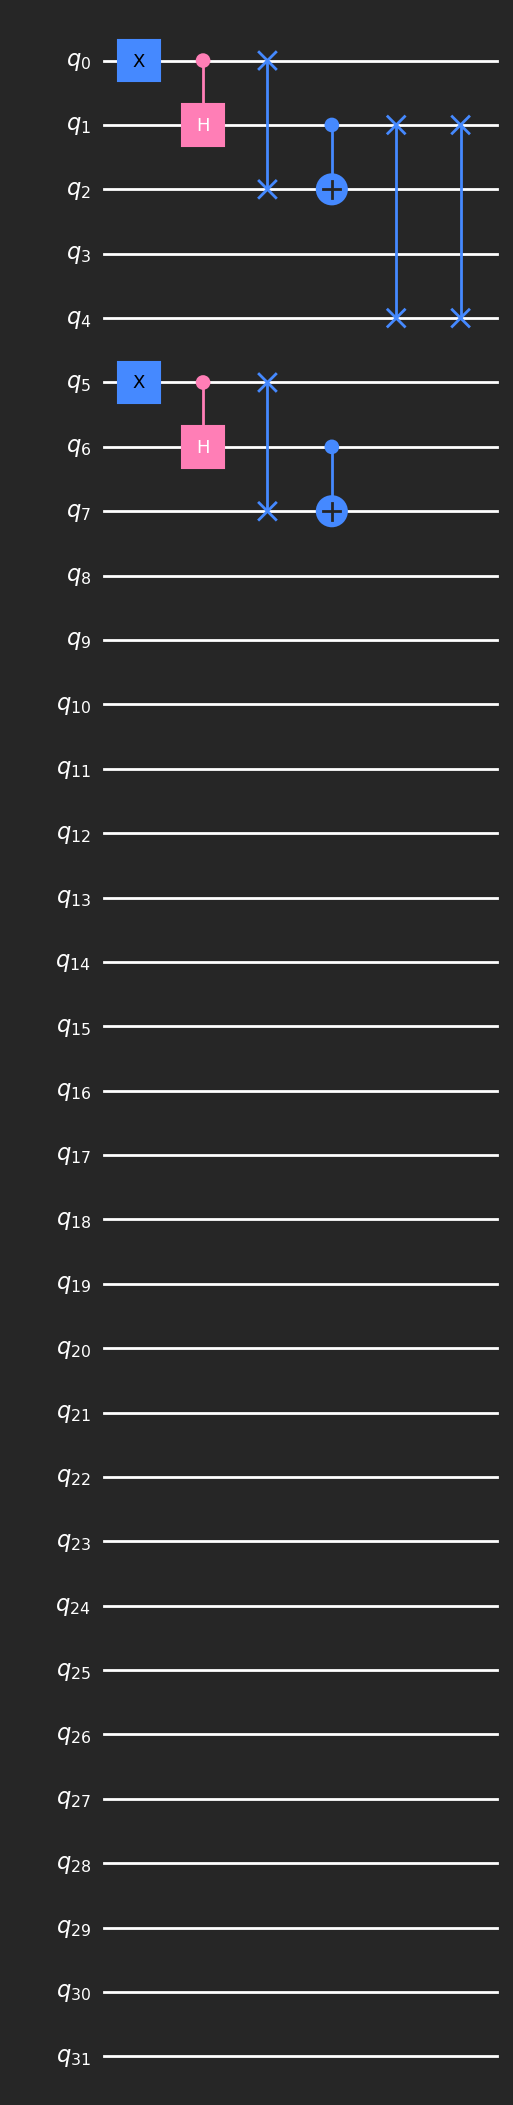

In [274]:
N = 32
qc = QuantumCircuit(N)
qc.x(0)
qc.ch(0, 1)
qc.swap(0, 2)
qc.cx(1, 2)
qc.swap(1,4)
qc.swap(1,4)

qc.x(5)
qc.ch(5, 6)
qc.swap(5, 7)
qc.cx(6, 7)


qc.draw('mpl', style="iqp-dark")

In [275]:
# FROM QISKIT DEVELOPERS
# DOES NOT CHANGE CLASSICAL QUBITS
# def count_gates(qc: QuantumCircuit):
#     gate_count = { qubit: 0 for qubit in qc.qubits }
#     for gate in qc.data:
#         for qubit in gate.qubits:
#             gate_count[qubit] += 1
#     return gate_count

# def remove_idle_wires(qc: QuantumCircuit):
#     qc_out = qc.copy()
#     gate_count = count_gates(qc_out)
#     for qubit, count in gate_count.items():
#         if count == 0:
#             qc_out.qubits.remove(qubit)
#     return qc_out

def count_gates(qc: QuantumCircuit):
    gate_count = {qubit: 0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count

def remove_idle_wires(qc: QuantumCircuit):
    # Count gate usage for each qubit
    gate_count = count_gates(qc)

    # Identify active qubits
    active_qubits = [qubit for qubit, count in gate_count.items() if count > 0]
    print(active_qubits)

    # Create a new circuit with only active qubits
    qc_out = QuantumCircuit(len(active_qubits), len(active_qubits))

    # Map old qubits to new qubits
    qubit_map = {qubit: i for i, qubit in enumerate(active_qubits)}

    # Copy instructions while updating qubit indices
    for instruction, qargs, cargs in qc.data:
        new_qargs = [qubit_map[q] for q in qargs if q in qubit_map]
        qc_out.append(instruction, new_qargs, cargs)

    return qc_out, [active_qubits[i]._index for i in range(len(active_qubits))]

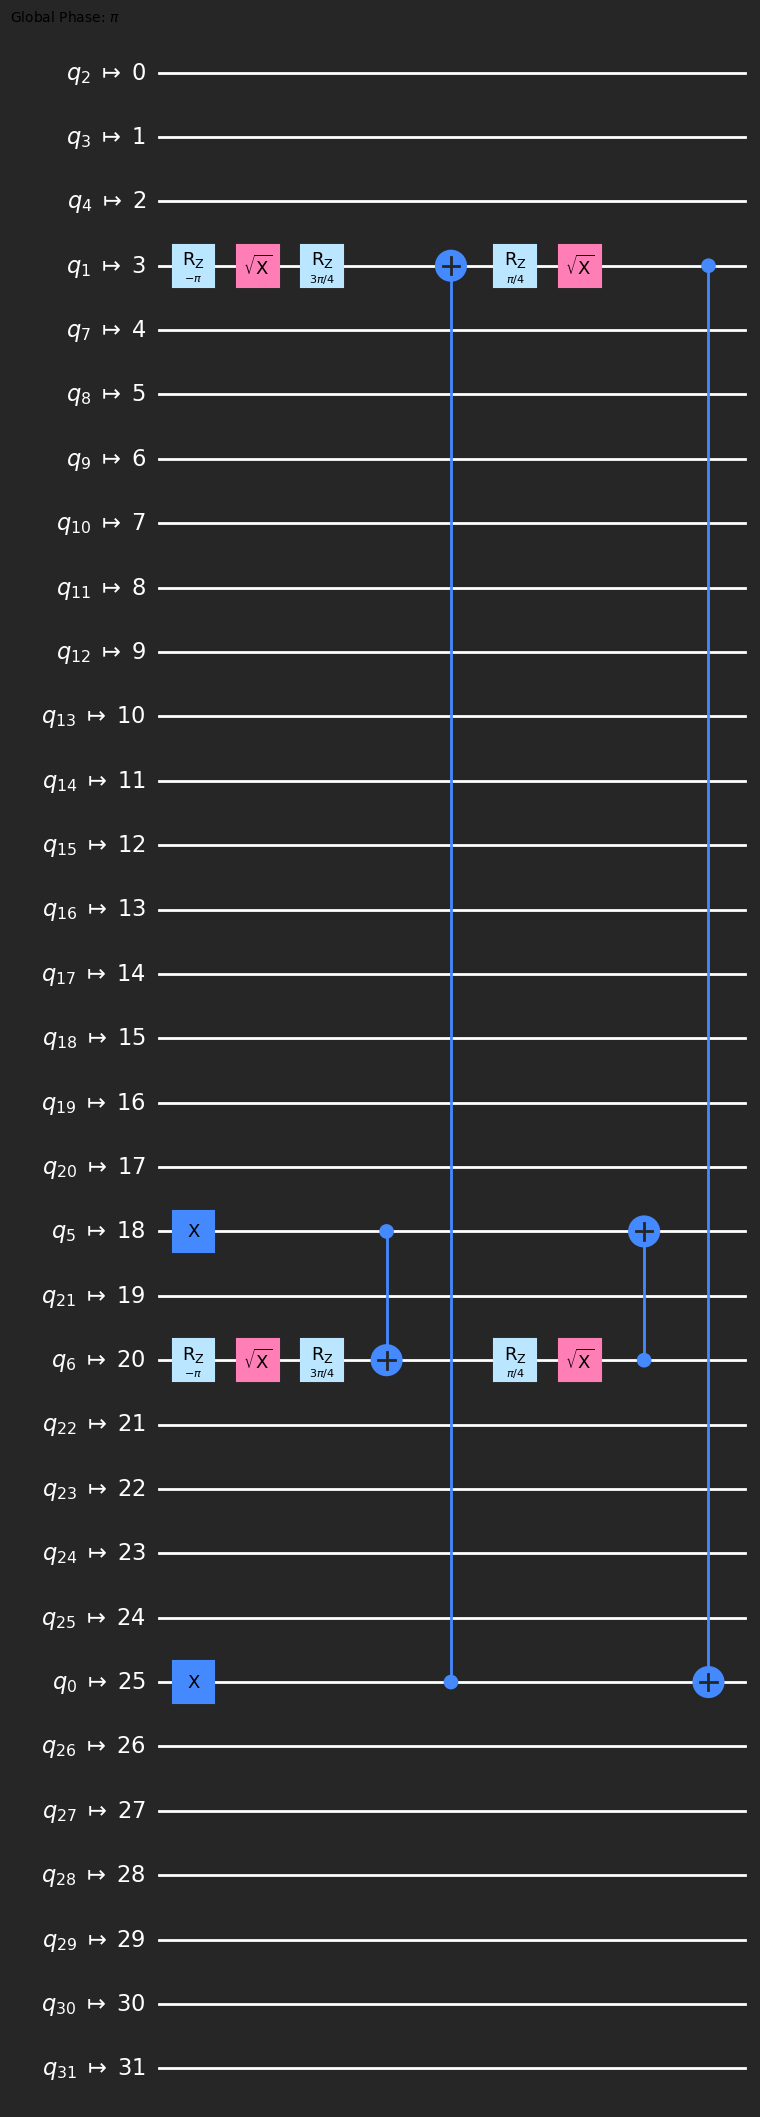

In [276]:
backend = GenericBackend(N)
transpiled_qc = transpile(qc, backend)
transpiled_qc.draw('mpl', style = 'iqp-dark')

[Qubit(QuantumRegister(32, 'q'), 3), Qubit(QuantumRegister(32, 'q'), 18), Qubit(QuantumRegister(32, 'q'), 20), Qubit(QuantumRegister(32, 'q'), 25)]
[3, 18, 20, 25] [0, 3, 25, 1, 2, 4, 20, 18, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31]
[1, 7, 6, 2]


C:\Users\terlo\AppData\Local\Temp\ipykernel_12160\3412884199.py:40: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instruction, qargs, cargs in qc.data:


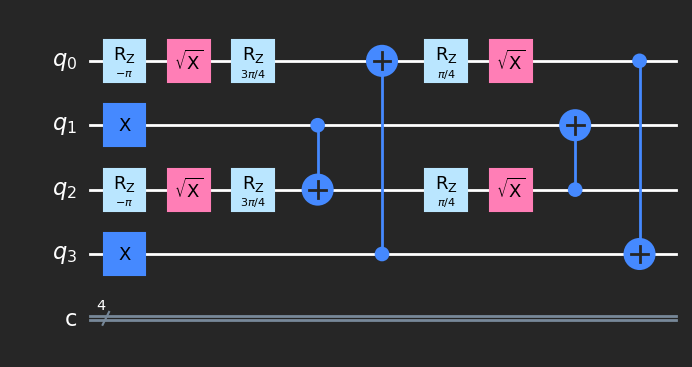

In [277]:
qc, active_qubits = remove_idle_wires(transpiled_qc)
print(active_qubits, transpiled_qc.layout.final_index_layout())
old_qubits = [transpiled_qc.layout.final_index_layout().index(i) for i in active_qubits]
print(old_qubits)
qc.draw('mpl', style='iqp-dark')

In [278]:
backend = FakeSherbrooke()
optimization_level=2
simulator = True
shots = 1024

qc.measure_all()

pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
isa_circuit = pm.run(qc)
pub = (isa_circuit)

if simulator == False:
    sampler = Sampler(mode = backend)
else:
    sampler = Sampler(mode = AerSimulator())

job = sampler.run(pubs=[pub], shots = shots)
result = job.result()[0]
out_with_freq = result.data.meas.get_counts()

display(out_with_freq)

{'0011': 258, '1100': 228, '1010': 256, '0101': 282}

In [279]:
filter = 5 # with a shot of 1000, so if P < 0.5% the measurement is removed
filtered_data = {value/shots : [old_qubits[index] for index, char in enumerate(key[::-1]) if char == '1'] for key, value in out_with_freq.items() if value >= filter}
weights = list(filtered_data.keys())
positions = list(filtered_data.values())

chosen_positions = random.choices(positions, weights=weights, k=1)[0]

print(filtered_data)
print(chosen_positions)

{0.251953125: [1, 7], 0.22265625: [6, 2], 0.25: [7, 2], 0.275390625: [1, 6]}
[7, 2]
